In [3]:
import pandas as pd
import pandas_ta as ta
import datetime
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
import joblib
from sklearn.metrics import r2_score

In [4]:
df = pd.read_csv('../data/btc_15m_data_2018_to_2025.csv')
df.drop(columns=['Close time', 'Quote asset volume', 'Number of trades',  'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], inplace=True)
df.head()
df.set_index("Open time", inplace=True)
df.index = pd.to_datetime(df.index)




FileNotFoundError: [Errno 2] No such file or directory: '../data/btc_15m_data_2018_to_2025.csv'

In [ ]:
df.head()

,Open,High,Low,Close,Volume
Open time,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013
2018-01-01 00:15:00,13533.75,13550.87,13402.00,13521.12,98.136430
2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037
2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719
2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533


In [ ]:
# Adjusted indicators for short-term predictions
df.ta.sma(length=10, append=True)  # Short-term SMA
df.ta.ema(length=10, append=True)  # Short-term EMA
df.ta.wma(length=10, append=True)  # Short-term WMA
df.ta.macd(fast=5, slow=8, append=True)  # Faster MACD signals
df.ta.rsi(length=7, append=True)  # Shorter RSI for quicker overbought/oversold signals
df.ta.bbands(length=10, append=True)  # Shorter Bollinger Bands for volatility
df.ta.adx(length=7, append=True)  # Shorter ADX for quicker trend strength analysis
df.ta.stoch(length=7, append=True)  # Shorter Stochastic Oscillator
df.ta.willr(length=7, append=True)  # Shorter Williams %R
df.ta.roc(length=5, append=True)  # Shorter ROC for quicker momentum analysis
df.ta.cci(length=10, append=True)  # Shorter CCI for quicker overbought/oversold signals
df.ta.atr(length=7, append=True)  # Shorter ATR for quicker volatility analysis

# Additional indicators
df.ta.tsi(length=10, append=True)       # Shorter True Strength Index
df.ta.ichimoku(append=True)             # Ichimoku Cloud (default settings)
df.ta.obv(append=True)                  # On-Balance Volume (no window size)
df.ta.vwap(append=True)                 # Volume Weighted Average Price (no window size)
df.ta.donchian(length=10, append=True)  # Shorter Donchian Channels
df.ta.ema(length=5, append=True)        # Very short-term EMA


# Drop rows with NaN values after adding indicators
# df.dropna(inplace=True)
df.drop(columns=['ISB_26'])
# Display the first few rows of the updated DataFrame
df.dropna(inplace=True)


In [ ]:
def triple_barrier_labels(df, upper_pct=0.01, lower_pct=-0.01, max_hold=5):
    labels = []
    for i in range(len(df)):
        max_target = df['Close'].iloc[i] * (1 + upper_pct)
        min_target = df['Close'].iloc[i] * (1 + lower_pct)
        
        future_prices = df['Close'].iloc[i+1:i+max_hold+1]
        touch_upper = (future_prices > max_target).any()
        touch_lower = (future_prices < min_target).any()
        
        if touch_upper and not touch_lower:
            labels.append('Long')
        elif touch_lower and not touch_upper:
            labels.append('Short')
        else:
            labels.append('Neutral')
    return labels

df['Signal'] = triple_barrier_labels(df)


In [ ]:
# Drop OHLC and Adj Close cause we need only indicators (If we need it cause for now we need Close price for backtesting our strategy)
df.drop(['Open', 'High', 'Low' ], axis=1, inplace=True)
df.dropna(inplace=True)
# Now you can analyze indicator values at each signal point
long_condition = df['Signal'] == 'long'
short_condition = df['Signal'] == 'short'
neutral_condition = df['Signal'] == 'neutral'

long_indicators = df.loc[long_condition].select_dtypes(include=['float64']).mean()
short_indicators = df.loc[short_condition].select_dtypes(include=['float64']).mean()
neutral_indicators = df.loc[neutral_condition].select_dtypes(include=['float64']).mean()


# Finding relations between indicators, for example correlation matrix
correlation_matrix = df.select_dtypes(include=['float64']).corr()

# Mostly I care about Entering Position Long and Short
# print(f'\nCandle Look: {window_size}\n')
# print('Long Indicators:\n', long_indicators)
# print('Short Indicators:\n', short_indicators)
# print('Neutral Indicators:\n', neutral_indicators)
# print('Correlation Matrix:\n', correlation_matrix)

In [ ]:
df['Signal'].value_counts()

Signal
Neutral    211436
Short       20943
Long        20427
Name: count, dtype: int64

In [ ]:

# Remove NaN rows
df.dropna(inplace=True)
df.to_csv('../data/btc_15m_data_2018_to_2025_with_indicators8.csv')
# Label encode the target column``
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Signal'])

# Prepare data
X = df.drop(['Signal'], axis=1)
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Split the data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [ ]:
print(df['Signal'][0:5], y_encoded[0:5])

Open time
2018-01-01 19:15:00       Long
2018-01-01 19:30:00       Long
2018-01-01 19:45:00       Long
2018-01-01 20:00:00    Neutral
2018-01-01 20:15:00       Long
Name: Signal, dtype: object [0 0 0 1 0]


In [ ]:
parameters = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 1.0}

In [ ]:
# Fit the XGBoost model
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Initialize the XGBoost model
clf = XGBClassifier(
    parameters=parameters,
)

# Specify a validation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model
clf.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True  # Print metrics for each tree
)

[0]	validation_0-mlogloss:0.85102	validation_1-mlogloss:0.85152
[1]	validation_0-mlogloss:0.71114	validation_1-mlogloss:0.71201
[2]	validation_0-mlogloss:0.62415	validation_1-mlogloss:0.62502
[3]	validation_0-mlogloss:0.56824	validation_1-mlogloss:0.56933
[4]	validation_0-mlogloss:0.53138	validation_1-mlogloss:0.53284


/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "parameters" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-mlogloss:0.50628	validation_1-mlogloss:0.50804
[6]	validation_0-mlogloss:0.48944	validation_1-mlogloss:0.49156
[7]	validation_0-mlogloss:0.47725	validation_1-mlogloss:0.47983
[8]	validation_0-mlogloss:0.46879	validation_1-mlogloss:0.47216
[9]	validation_0-mlogloss:0.46217	validation_1-mlogloss:0.46606
[10]	validation_0-mlogloss:0.45751	validation_1-mlogloss:0.46195
[11]	validation_0-mlogloss:0.45371	validation_1-mlogloss:0.45874
[12]	validation_0-mlogloss:0.45060	validation_1-mlogloss:0.45620
[13]	validation_0-mlogloss:0.44736	validation_1-mlogloss:0.45366
[14]	validation_0-mlogloss:0.44459	validation_1-mlogloss:0.45170
[15]	validation_0-mlogloss:0.44242	validation_1-mlogloss:0.45032
[16]	validation_0-mlogloss:0.44020	validation_1-mlogloss:0.44864
[17]	validation_0-mlogloss:0.43842	validation_1-mlogloss:0.44759
[18]	validation_0-mlogloss:0.43628	validation_1-mlogloss:0.44629
[19]	validation_0-mlogloss:0.43461	validation_1-mlogloss:0.44536
[20]	validation_0-mlogloss:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# joblib.dump(clf, '../models/xgboost_model8.joblib')

In [ ]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order and match the feature names
sorted_indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in sorted_indices]

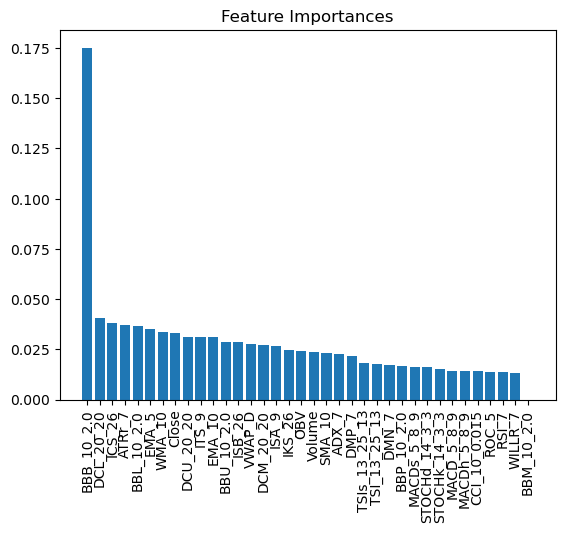

In [ ]:
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), sorted_names, rotation=90)
plt.show()

              precision    recall  f1-score   support

           0       0.55      0.16      0.25      2040
           1       0.87      0.99      0.92     21165
           2       0.54      0.15      0.24      2076

    accuracy                           0.85     25281
   macro avg       0.65      0.43      0.47     25281
weighted avg       0.81      0.85      0.81     25281

R2 Score: -0.09
ROC-AUC Score: 0.86


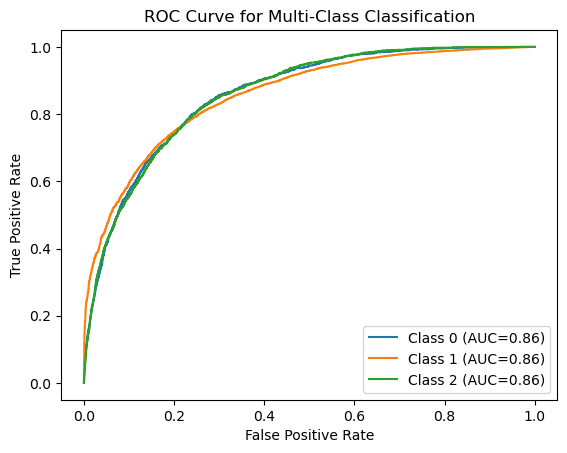

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Convert class labels to strings for classification_report
class_names = [str(cls) for cls in label_encoder.classes_]

# Generate classification report
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names)
print(report)

# Confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Predict probabilities
probabilities = clf.predict_proba(X_test)

# R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.2f}")

# Calculate ROC-AUC score
auc = roc_auc_score(y_test, probabilities, multi_class='ovr', average='macro')
print(f"ROC-AUC Score: {auc:.2f}")

# Binarize the true labels for each class
y_test_binarized = label_binarize(y_test, classes=clf.classes_)

# Plot ROC curve for each class
for i, class_name in enumerate(clf.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC={roc_auc_score(y_test_binarized[:, i], probabilities[:, i]):.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()


In [ ]:

print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {auc:.2f}")
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.2f})")
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()


              precision    recall  f1-score   support

           0       0.55      0.16      0.25      2040
           1       0.87      0.99      0.92     21165
           2       0.54      0.15      0.24      2076

    accuracy                           0.85     25281
   macro avg       0.65      0.43      0.47     25281
weighted avg       0.81      0.85      0.81     25281

Accuracy: 0.85
ROC-AUC Score: 0.86
